In [1]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *


#path dove stanno i dati del fit
now_path        =   '../BRILLOUIN/TDP43/NO_ARS_12_02/analysis_again/'

### recupero info su dimensionalità
spectra_path = '../BRILLOUIN/TDP43/NO_ARS_12_02/'
spectra_filename    =   'NO_ARS_12_02'
n_rows    =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3'))
n_cols  =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3')[0])
###
matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 101x83, per un totale di 8383 spettri


In [2]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)


for (ii,jj) in boni:
    matrix[ii][jj].Recover_VIPA(x_VIPA, y_VIPA)


count = 0
for (ii,jj) in serpentine_range(n_rows, n_cols, 'right'):
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [3]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni parametri fit ({})".format(len(boni), len(lines)))
if (len(boni) != len(costi)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni costo fit ({})".format(len(boni), len(costi)))
if (len(boni) != len(y_fits)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e y fit ({})".format(len(boni), len(y_fits)))


for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')




Ok ho recuperato le informazioni del Fit Markoviano


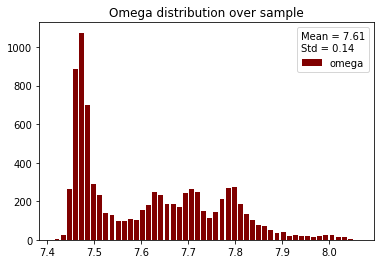

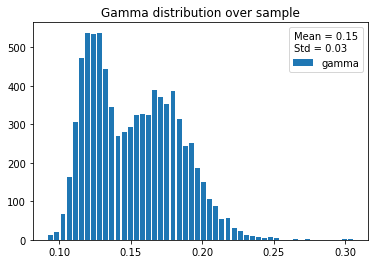

In [4]:
#HISTOGRAMs - MARKOV
markov_Omegas = np.array([matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
markov_Gammas =  np.array([matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])


plt.figure()
plt.title('Omega distribution over sample')
_ = plt.hist(markov_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Omegas), np.std(markov_Omegas)))
plt.savefig(now_path+'Omega_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample')
_ = plt.hist(markov_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Gammas), np.std(markov_Gammas)))
plt.savefig(now_path+'Gamma_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


In [20]:
#Parametri di Interesse per analisi
markov_too_bad = ()
markov_too_good  = ()
markov_omega_too_high =  ()
markov_gamma_too_bad = ()

markov_omega_max = np.mean(markov_Omegas)+5*np.std(markov_Omegas)
markov_gamma_max = np.mean(markov_Gammas)+5*np.std(markov_Gammas)
cost_max = 1000
cost_min = 50


markov_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'markov')
markov_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'markov')
markov_omega_too_high = Whose_Param_Too_High('Omega', markov_omega_max, 'markov', matrix, boni)
markov_gamma_too_high = Whose_Param_Too_High('Gamma', markov_gamma_max, 'markov', matrix, boni)


#aggiunte 
markov_too_offset = ()
percentage_gamma = 15
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    if matrix[ii][jj].Markov_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Markov_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        markov_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Markov_Fit_Params['offset'].values[0] > max_offset:
        markov_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        markov_almost_height += ((ii,jj),)


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(markov_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(markov_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(markov_omega_too_high), markov_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(markov_gamma_too_high), markov_gamma_max))

print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(markov_too_offset), max_offset))





I found 0 bad elements out of 8317

I found 2202 good elements out of 8317

(34, 51) ha Gamma= 0.31




Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/NO_ARS_12_02/analysis_again/ :

0 elementi con chi quadro > 1000 
2202 elementi con chi quadro < 50 

0 elementi con Omega > Omega max 8.33
1 elementi con Gamma > Gamma max 0.30

0 elementi con Gamma con errore percentuale > 15 

0 elementi con offset > 30 



(34, 51)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.021168  7.911739  0.305790        1.414433     0.588207   
StdErrs   0.009609  0.031153  0.025098        0.250851     0.179520   
Initials  0.015873  7.779978  0.206715        1.567365     0.619394   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.367880  1.607553e+03  -5.975447  15.109808  0.097216   
StdErrs          0.178680  2.064152e+09  11.170116   8.953611  0.028632   
Initials         0.393909  2.001641e+03  -6.035804  15.124932  0.134286   

            offset  
Values    2.000000  
StdErrs   2.453337  
Initials  2.000000  


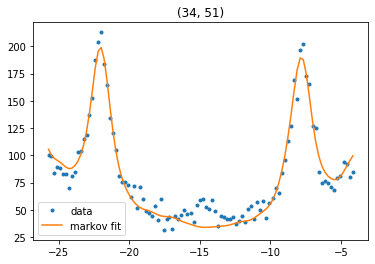

In [6]:
Plot_Elements_Spectrum(matrix, markov_gamma_too_high, fit = 'markov')

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


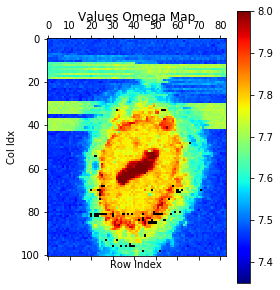

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


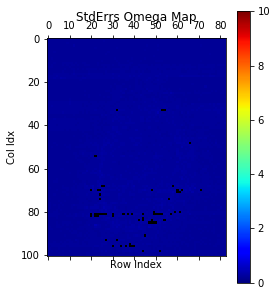

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


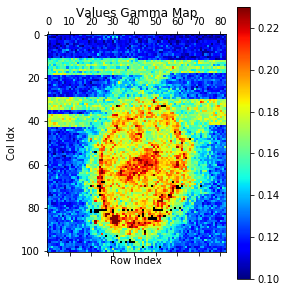

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


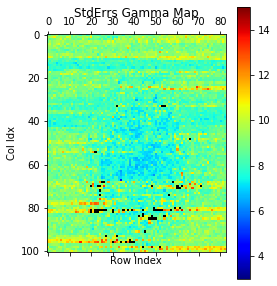

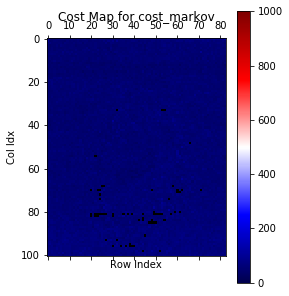

In [7]:
#MAPPE
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_markov_map', path=now_path)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,10, fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.23, fig = 'Gamma_markov_map', path=now_path)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 3, 15, fig = 'Delta_Gamma_markov_map', path=now_path, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

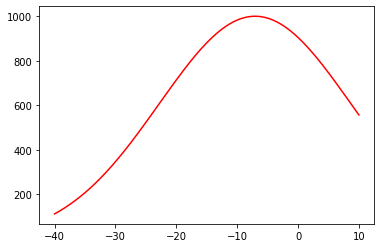

,mu,sigma
Values,-7.056819,15.764936
StdErrs,17.635290,16.720776
Initials,-6.986950,15.749186


In [8]:
plt.figure()
x = np.linspace(-40, 10, 5000)
for (ii,jj) in boni[-1:]:
    plt.plot(x, gaussian(x, 1000, *matrix[ii][jj].Markov_Fit_Params[list(cols_gauss)].values[0][1:]), c = 'r')
    plt.show()
matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']]


In [21]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


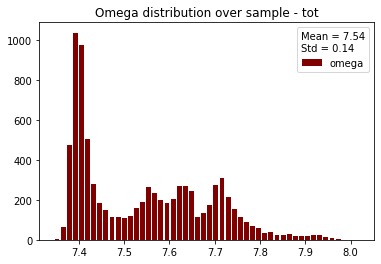

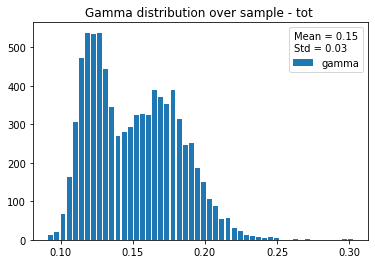

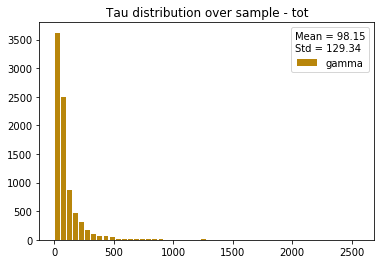

In [22]:
#HISTOGRAMs
tot_Omegas = np.array([matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
tot_Gammas =  np.array([matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])
taus       = np.array([matrix[ii][jj].Tot_Fit_Params['tau'].values[0] for (ii,jj) in boni])

plt.figure()
plt.title('Omega distribution over sample - tot')
_ = plt.hist(tot_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Omegas), np.std(tot_Omegas)))
plt.savefig(now_path+'Omega_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample - tot ')
_ = plt.hist(tot_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Gammas), np.std(tot_Gammas)))
plt.savefig(now_path+'Gamma_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Tau distribution over sample - tot')
_ = plt.hist(taus, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8, color = 'darkgoldenrod')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(taus), np.std(taus)))
plt.savefig(now_path+'tau_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


In [27]:
#Parametri di Interesse per analisi
tot_too_bad = ()
tot_too_good  = ()
tot_omega_too_high =  ()
tot_gamma_too_bad = ()
tau_not_bad = []

tot_omega_max = np.mean(tot_Omegas)+5*np.std(tot_Omegas)
tot_gamma_max = np.mean(tot_Gammas)+5*np.std(tot_Gammas)
cost_max = 1000
cost_min = 50


tot_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'tot')
tot_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'tot')
tot_omega_too_high = Whose_Param_Too_High('Omega', tot_omega_max, 'markov', matrix, boni)
tot_gamma_too_high = Whose_Param_Too_High('Gamma', tot_gamma_max, 'markov', matrix, boni)


#aggiunte 
omega_different_from_mark = []
gamma_different_from_mark = []

percentage_diff = 0.8
tot_too_offset = ()
percentage_gamma = 100
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    
    perc_omega = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100
    perc_gamma = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100

    if (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] > matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] < matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] - perc_gamma):
        omega_different_from_mark.append((ii,jj))
    if (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] > matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] < matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] - perc_omega):
        gamma_different_from_mark.append((ii,jj))
    if matrix[ii][jj].Tot_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Tot_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        tot_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['offset'].values[0] > max_offset:
        tot_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        tot_almost_height += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['tau']['StdErrs'] < matrix[ii][jj].Tot_Fit_Params['tau']['Values']:
        tau_not_bad.append((ii,jj))


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(tot_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(tot_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(tot_omega_too_high), tot_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(tot_gamma_too_high), tot_gamma_max))


print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(tot_too_offset), max_offset))

print('{} elementi il cui fit tot di Omega è diverso del {} percento da markoviano'.format(len(omega_different_from_mark), percentage_diff))
print('{} elementi il cui fit tot di Gamma è diverso del {} percento da markoviano'.format(len(gamma_different_from_mark), percentage_diff))
print('{} elementi il cui fit di tau non è cosi male..'.format(len(tau_not_bad)), tau_not_bad)


I found 6142 bad elements out of 8317

I found 2 good elements out of 8317

(34, 51) ha Gamma= 0.31




Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/NO_ARS_12_02/analysis_again/ :

6142 elementi con chi quadro > 1000 
2 elementi con chi quadro < 50 

0 elementi con Omega > Omega max 8.25
1 elementi con Gamma > Gamma max 0.30

0 elementi con Gamma con errore percentuale > 100 

0 elementi con offset > 30 

8144 elementi il cui fit tot di Omega è diverso del 0.8 percento da markoviano
0 elementi il cui fit tot di Gamma è diverso del 0.8 percento da markoviano
0 elementi il cui fit di tau non è cosi male.. []


In [ ]:
Plot_Elements_Spectrum(matrix, tau_not_bad[:10], fit = 'tot')

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


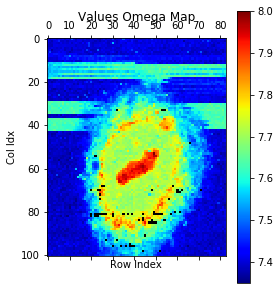

Completata Parameter_Map per Omega
Ho trovato 66 elementi saturati


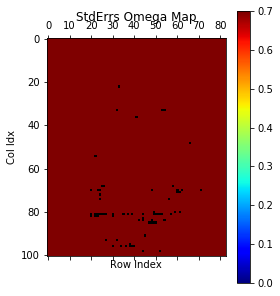

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


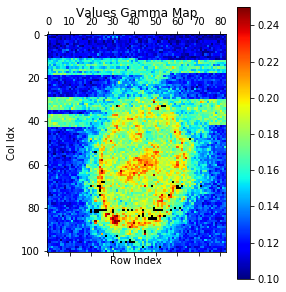

Completata Parameter_Map per Gamma
Ho trovato 66 elementi saturati


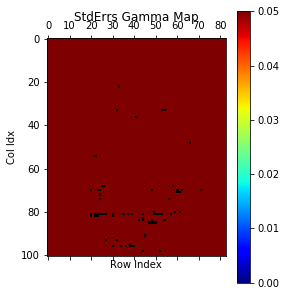

Completata Parameter_Map per tau
Ho trovato 66 elementi saturati


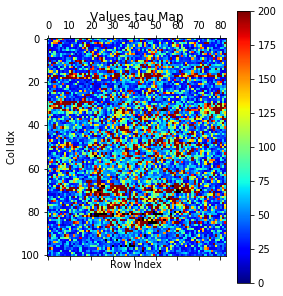

Completata Parameter_Map per tau
Ho trovato 66 elementi saturati


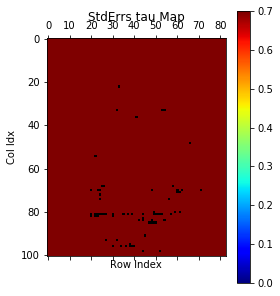

In [31]:
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_tot_map', path=now_path)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_omega_tot_map', path=now_path, Deltas = True)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.25, fig = 'Gamma_tot_map', path=now_path)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0,0.05, fig = 'Delta_gamma_tot_map', path=now_path, Deltas = True)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0., 200, fig = 'tau_map', path=now_path)
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_tau_map', path=now_path, Deltas = True)

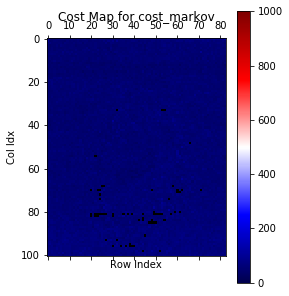

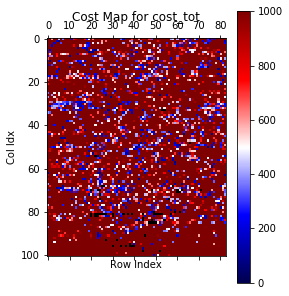

In [29]:
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)
tot_cost_map = Get_cost_map(matrix, 'tot', len(rows), len(cols), 'tot_cost_map', path = now_path)
